In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

import scanpy as sc

In [2]:
# to use magic command %%R
%load_ext rpy2.ipython 

In [3]:
%%R
library(GenotypeMixtures)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.0 
✔ readr   2.1.3      ✔ forcats 0.5.1 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Samples

In [4]:
multiplexed_samples = pd.read_csv('/nfs/team205/heart/mapped/cellranger-arc200/csv/multiome-foetal_20221221.csv')
multiplexed_samples

,combinedID,Mapping_iRODS
0,7089STDY13216920_BHF_F_Hea13242527,/seq/illumina/cellranger-arc/cellranger-arc200...
1,7089STDY13216921_BHF_F_Hea13242528,/seq/illumina/cellranger-arc/cellranger-arc200...
2,7089STDY13216922_BHF_F_Hea13242529,/seq/illumina/cellranger-arc/cellranger-arc200...
3,7089STDY13216923_BHF_F_Hea13242530,/seq/illumina/cellranger-arc/cellranger-arc200...
4,7089STDY13216924_BHF_F_Hea13242531,/seq/illumina/cellranger-arc/cellranger-arc200...
5,7089STDY13216925_BHF_F_Hea13242532,/seq/illumina/cellranger-arc/cellranger-arc200...
6,7089STDY13216926_BHF_F_Hea13242533,/seq/illumina/cellranger-arc/cellranger-arc200...
7,7089STDY13216927_BHF_F_Hea13242534,/seq/illumina/cellranger-arc/cellranger-arc200...


In [5]:
# read in metadata
meta = pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/metadata/HeartTeamSamples_Mappeddata_20221223.csv', sep = ',', index_col = None)
meta = meta[meta['Publication']=='Foetal']
meta = meta[['sangerID', 'combinedID',
       'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender',
       'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed',
       'status']]

# select samples
meta = meta[meta['combinedID'].isin(multiplexed_samples['combinedID'])]

# select Multiome-ATAC
meta = meta[meta['modality']=='Multiome-ATAC']

# reindex
meta.index = range(len(meta))

meta

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status
0,BHF_F_Hea13242527,7089STDY13216920_BHF_F_Hea13242527,"Hst39, Hst40",na,"Aorta (Hst39), Nodes (Hst40)","Aorta (Hst39), Nodes (Hst40)",multiplexed,multiplexed,Sanger,Nuclei,Multiome-ATAC,Multiome-v1,na,Healthy
1,BHF_F_Hea13242528,7089STDY13216921_BHF_F_Hea13242528,"Hst39, Hst40",na,"Aorta (Hst39), Nodes (Hst40)","Aorta (Hst39), Nodes (Hst40)",multiplexed,multiplexed,Sanger,Nuclei,Multiome-ATAC,Multiome-v1,na,Healthy
2,BHF_F_Hea13242529,7089STDY13216922_BHF_F_Hea13242529,"Hst36, Hst39, Hst40",na,"Heart (Hst36), Heart-wo-nodes (Hst39), Heart-w...","Heart (Hst36), Heart-wo-nodes (Hst39), Heart-w...",multiplexed,multiplexed,Sanger,Nuclei,Multiome-ATAC,Multiome-v1,na,Healthy
3,BHF_F_Hea13242530,7089STDY13216923_BHF_F_Hea13242530,"Hst36, Hst39, Hst40",na,"Heart (Hst36), Heart-wo-nodes (Hst39), Heart-w...","Heart (Hst36), Heart-wo-nodes (Hst39), Heart-w...",multiplexed,multiplexed,Sanger,Nuclei,Multiome-ATAC,Multiome-v1,na,Healthy
4,BHF_F_Hea13242531,7089STDY13216924_BHF_F_Hea13242531,Hst39,na,Nodes,Nodes,PCW-15w,Female,Sanger,Nuclei,Multiome-ATAC,Multiome-v1,na,Healthy
5,BHF_F_Hea13242532,7089STDY13216925_BHF_F_Hea13242532,Hst40,na,Heart-wo-nodes,Heart-wo-nodes,PCW-14w,Male,Sanger,Nuclei,Multiome-ATAC,Multiome-v1,na,Healthy
6,BHF_F_Hea13242533,7089STDY13216926_BHF_F_Hea13242533,Hst39,na,Heart-wo-nodes,Heart-wo-nodes,PCW-15w,Female,Sanger,Nuclei,Multiome-ATAC,Multiome-v1,na,Healthy
7,BHF_F_Hea13242534,7089STDY13216927_BHF_F_Hea13242534,Hst36,na,Heart,Heart,PCW-12w,Female,Sanger,Nuclei,Multiome-ATAC,Multiome-v1,na,Healthy


# Read in and concatenate clusters.tsv

In [6]:
# min-ref/alt = 4
clusters_all = {}
multiplexed_IDs = ['7089STDY13216920_BHF_F_Hea13242527',
                   '7089STDY13216921_BHF_F_Hea13242528',
                   '7089STDY13216922_BHF_F_Hea13242529',
                   '7089STDY13216923_BHF_F_Hea13242530']

for i,ID in enumerate(multiplexed_IDs):
    df = pd.read_csv(f'/nfs/team205/heart/mapped/cellranger-arc200/SOC_out/{ID}/ATAC_SOC_common_variants/clusters.tsv', sep='\t')
    df['sample'] = ID
    if i==0:
        clusters_all = df.copy()
    else:
        clusters_all = pd.concat([clusters_all,df])
clusters_all = clusters_all[['sample', 'barcode', 'status', 'assignment', 'log_prob_singleton',
                           'log_prob_doublet', 'cluster0', 'cluster1', 'cluster2']]

# combine sample and barcode name: adata.obs_names
clusters_all['obsnames'] = clusters_all['sample'].astype('str')+'_'+clusters_all['barcode'].astype('str')
clusters_all.set_index('obsnames',inplace=True)

print(clusters_all['status'].value_counts())
clusters_all

singlet       63170
doublet        8383
unassigned     3431
Name: status, dtype: int64


,sample,barcode,status,assignment,log_prob_singleton,log_prob_doublet,cluster0,cluster1,cluster2
obsnames,,,,,,,,,
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1,7089STDY13216920_BHF_F_Hea13242527,GCCCTCATCCTAGTAA-1,singlet,1,-1804.326000,-2214.313429,-3702.970109,-1804.326000,NaN
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1,7089STDY13216920_BHF_F_Hea13242527,ACTCGCTTCCTAGTAA-1,singlet,0,-2300.029401,-2917.765214,-2300.029401,-4878.822776,NaN
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1,7089STDY13216920_BHF_F_Hea13242527,TGGTCCTTCCGTGACA-1,singlet,0,-7138.100603,-8752.227197,-7138.100603,-15143.684314,NaN
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1,7089STDY13216920_BHF_F_Hea13242527,TTCAGTTTCCGCTAGA-1,singlet,1,-16501.683493,-20232.559001,-36208.064251,-16501.683493,NaN
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1,7089STDY13216920_BHF_F_Hea13242527,GTCAATATCATCCACC-1,singlet,0,-15506.974212,-16020.863109,-15506.974212,-25471.286877,NaN
...,...,...,...,...,...,...,...,...,...
7089STDY13216923_BHF_F_Hea13242530_AAACGCGCATAGCGAG-1,7089STDY13216923_BHF_F_Hea13242530,AAACGCGCATAGCGAG-1,singlet,0,-3.026923,-3.493628,-3.026923,-10.350458,-3.638696
7089STDY13216923_BHF_F_Hea13242530_GCAAGTCGTGGTTAGC-1,7089STDY13216923_BHF_F_Hea13242530,GCAAGTCGTGGTTAGC-1,singlet,0,-30.336645,-36.629492,-30.336645,-38.894944,-66.872272
7089STDY13216923_BHF_F_Hea13242530_GTGTTCCTCGCATCCT-1,7089STDY13216923_BHF_F_Hea13242530,GTGTTCCTCGCATCCT-1,unassigned,1,-7.532333,-7.726146,-8.440497,-7.532333,-8.338671


In [10]:
set(clusters_all['sample'])

{'7089STDY13216920_BHF_F_Hea13242527',
 '7089STDY13216921_BHF_F_Hea13242528',
 '7089STDY13216922_BHF_F_Hea13242529',
 '7089STDY13216923_BHF_F_Hea13242530'}

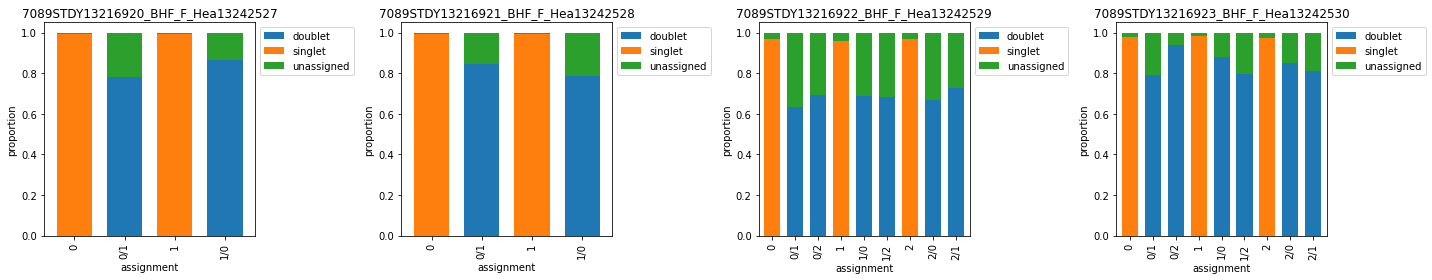

In [11]:
# proportion of status in each genotype assignment
# most of them are singlet in single genotype assignment which is good
df = clusters_all.copy()

fig, axs = plt.subplots(nrows=1, ncols=len(multiplexed_IDs), figsize=(20,4)) 

for i,sam in enumerate(multiplexed_IDs):

    df = clusters_all[clusters_all['sample']==sam]
    tmp = pd.crosstab(df['assignment'], df['status'], normalize='index')
    # tmp.plot.bar().legend(loc=1)
    tmp.plot.bar(stacked=True,width=0.7,ax=axs[i])
    axs[i].grid(False)
    axs[i].set_ylabel('proportion')
    axs[i].set_title(sam)
    axs[i].legend(bbox_to_anchor=(1.0, 1.0))
    
plt.tight_layout()

will assign donors as below
* 'assignment': single cluster
* 'status': 'singlet'

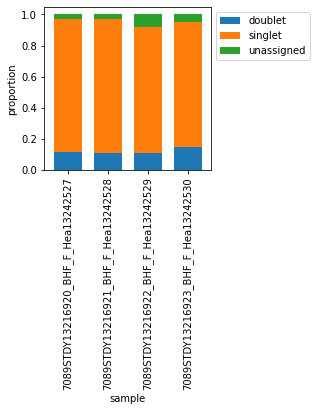

In [12]:
# Proportion of status in each sample
# most are singlet
df = clusters_all.copy()
plt.rcParams['figure.figsize'] = 3,3
tmp = pd.crosstab(df['sample'], df['status'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.7)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()
plt.show()

# Genotype matching

In [13]:
# prepare the column for donor assignment
clusters_all['donor_assignment'] = 'donor_unassigned'

In [14]:
%%R -i meta
# prepare wrapper function
plot_result = function(ID, Donor){
    output_dir = '/nfs/team205/heart/mapped/cellranger-arc200/SOC_out/'
    
    if (Donor == 'Hst39'){
        ID_ref = '7089STDY13216926_BHF_F_Hea13242533'
    }else{
        ID_ref = meta %>% filter(donor==Donor) %>% pull(combinedID)
    }
    
    plot_cross_vaf(experiment_1_path = paste0(output_dir,ID,'/ATAC_SOC_common_variants/'), 
                   experiment_2_path = paste0(output_dir,ID_ref,'/ATAC_SOC_common_variants/'), 
                   experiment_1_name = strsplit(ID,'_')[[1]][1],
                   experiment_2_name = Donor)
}

## 7089STDY13216920_BHF_F_Hea13242527

In [15]:
targetID = '7089STDY13216920_BHF_F_Hea13242527'

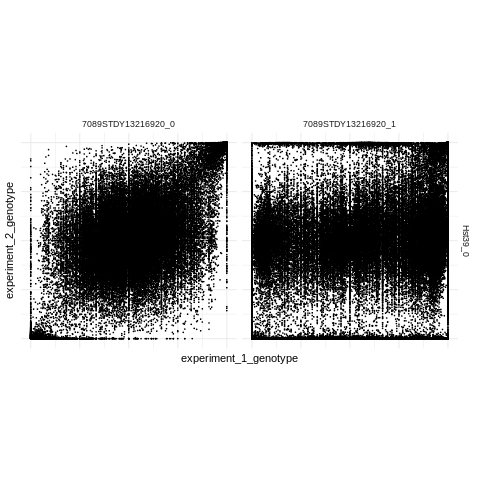

In [10]:
%%R -i targetID
plot_result(ID=targetID, Donor='Hst39')

In [16]:
# assign donors
obsnames = clusters_all.index[(clusters_all['sample']==targetID)&\
                              (clusters_all['status']=='singlet')&\
                              (clusters_all['assignment']=='0')]
clusters_all.loc[obsnames,'donor_assignment'] = 'Hst39'
targetID

'7089STDY13216920_BHF_F_Hea13242527'

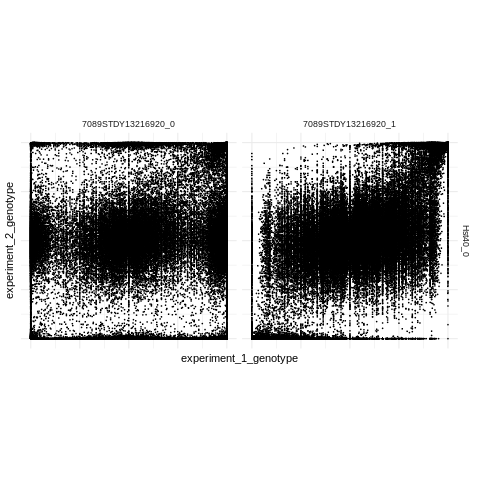

In [11]:
%%R -i targetID
plot_result(ID=targetID, Donor='Hst40')

In [17]:
# assign donors
obsnames = clusters_all.index[(clusters_all['sample']==targetID)&\
                              (clusters_all['status']=='singlet')&\
                              (clusters_all['assignment']=='1')]
clusters_all.loc[obsnames,'donor_assignment'] = 'Hst40'
targetID

'7089STDY13216920_BHF_F_Hea13242527'

## 7089STDY13216921_BHF_F_Hea13242528

In [18]:
targetID = '7089STDY13216921_BHF_F_Hea13242528'

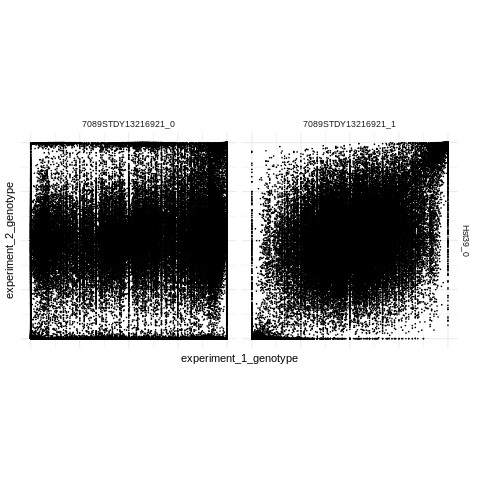

In [13]:
%%R -i targetID
plot_result(ID=targetID, Donor='Hst39')

In [19]:
# assign donors
obsnames = clusters_all.index[(clusters_all['sample']==targetID)&\
                              (clusters_all['status']=='singlet')&\
                              (clusters_all['assignment']=='1')]
clusters_all.loc[obsnames,'donor_assignment'] = 'Hst39'
targetID

'7089STDY13216921_BHF_F_Hea13242528'

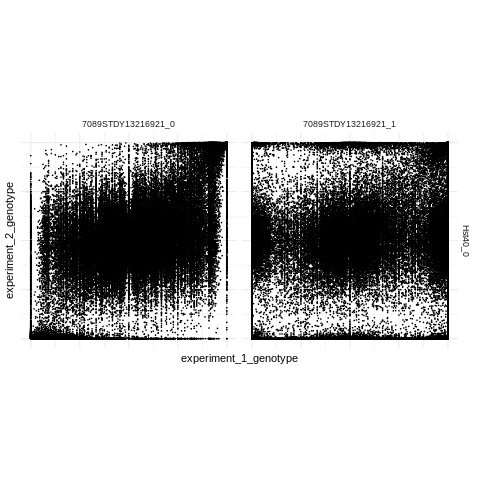

In [14]:
%%R -i targetID
plot_result(ID=targetID, Donor='Hst40')

In [20]:
# assign donors
obsnames = clusters_all.index[(clusters_all['sample']==targetID)&\
                              (clusters_all['status']=='singlet')&\
                              (clusters_all['assignment']=='0')]
clusters_all.loc[obsnames,'donor_assignment'] = 'Hst40'
targetID

'7089STDY13216921_BHF_F_Hea13242528'

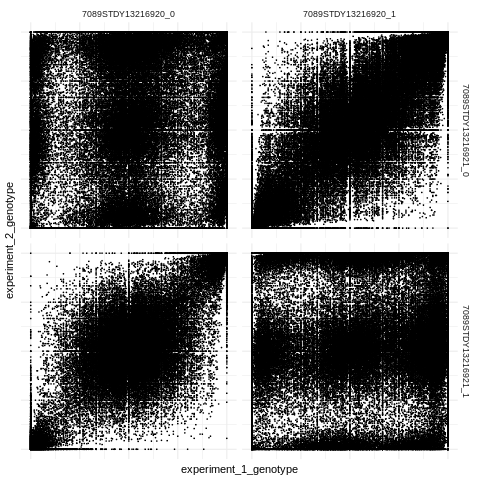

In [38]:
%%R
output_dir = '/nfs/team205/heart/mapped/cellranger-arc200/SOC_out/'
plot_cross_vaf(experiment_1_path = paste0(output_dir,'7089STDY13216920_BHF_F_Hea13242527','/ATAC_SOC_common_variants/'), 
                   experiment_2_path = paste0(output_dir,'7089STDY13216921_BHF_F_Hea13242528','/ATAC_SOC_common_variants/'), 
                   experiment_1_name = '7089STDY13216920',
                   experiment_2_name = '7089STDY13216921')

## 7089STDY13216922_BHF_F_Hea13242529

In [21]:
targetID = '7089STDY13216922_BHF_F_Hea13242529'

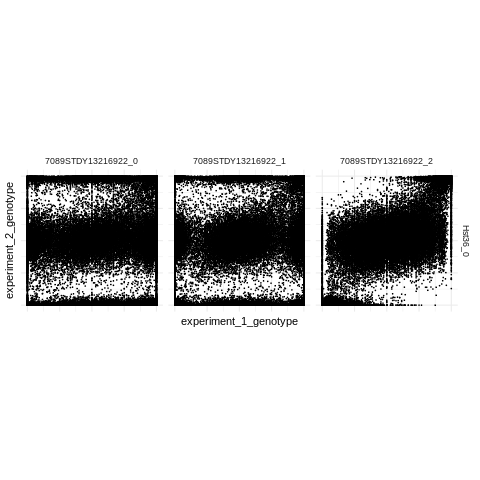

In [16]:
%%R -i targetID
plot_result(ID=targetID, Donor='Hst36')

In [22]:
# assign donors
obsnames = clusters_all.index[(clusters_all['sample']==targetID)&\
                              (clusters_all['status']=='singlet')&\
                              (clusters_all['assignment']=='2')]
clusters_all.loc[obsnames,'donor_assignment'] = 'Hst36'
targetID

'7089STDY13216922_BHF_F_Hea13242529'

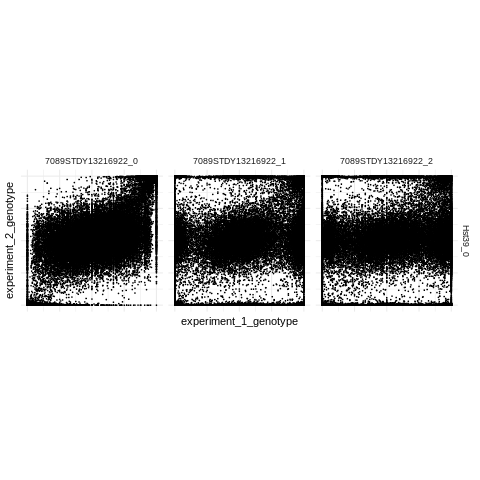

In [17]:
%%R -i targetID
plot_result(ID=targetID, Donor='Hst39')

In [23]:
# assign donors
obsnames = clusters_all.index[(clusters_all['sample']==targetID)&\
                              (clusters_all['status']=='singlet')&\
                              (clusters_all['assignment']=='0')]
clusters_all.loc[obsnames,'donor_assignment'] = 'Hst39'
targetID

'7089STDY13216922_BHF_F_Hea13242529'

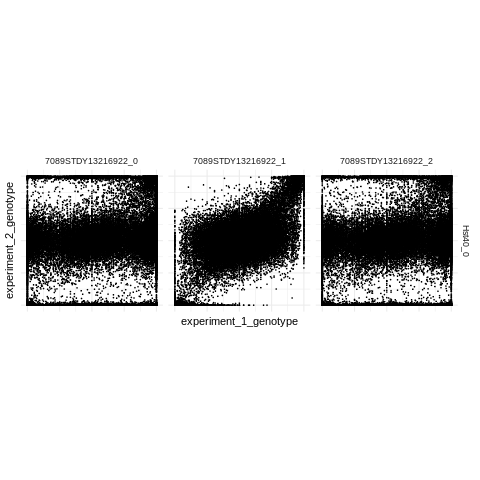

In [18]:
%%R -i targetID
plot_result(ID=targetID, Donor='Hst40')

In [24]:
# assign donors
obsnames = clusters_all.index[(clusters_all['sample']==targetID)&\
                              (clusters_all['status']=='singlet')&\
                              (clusters_all['assignment']=='1')]
clusters_all.loc[obsnames,'donor_assignment'] = 'Hst40'
targetID

'7089STDY13216922_BHF_F_Hea13242529'

## 7089STDY13216923_BHF_F_Hea13242530

In [25]:
targetID = '7089STDY13216923_BHF_F_Hea13242530'

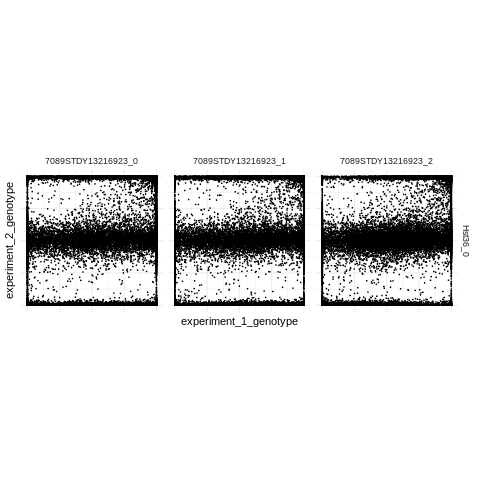

In [20]:
%%R -i targetID
plot_result(ID=targetID, Donor='Hst36')

In [ ]:
'''
obsnames = clusters_all.index[(clusters_all['sample']==targetID)&(clusters_all['assignment']==    )]
clusters_all.loc[obsnames,'donor_assignment'] = 'Hst36'
targetID
'''

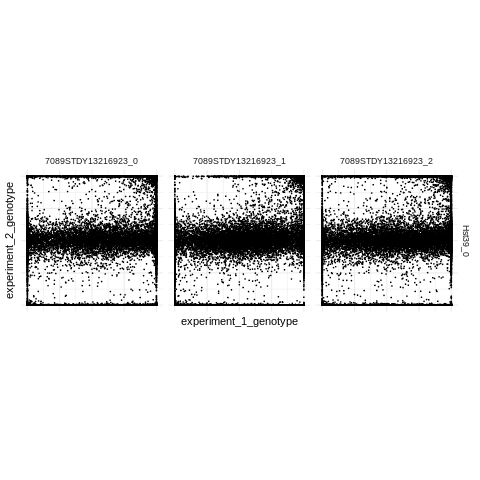

In [21]:
%%R -i targetID
plot_result(ID=targetID, Donor='Hst39')

In [ ]:
'''
obsnames = clusters_all.index[(clusters_all['sample']==targetID)&(clusters_all['assignment']==    )]
clusters_all.loc[obsnames,'donor_assignment'] = 'Hst39'
targetID
'''

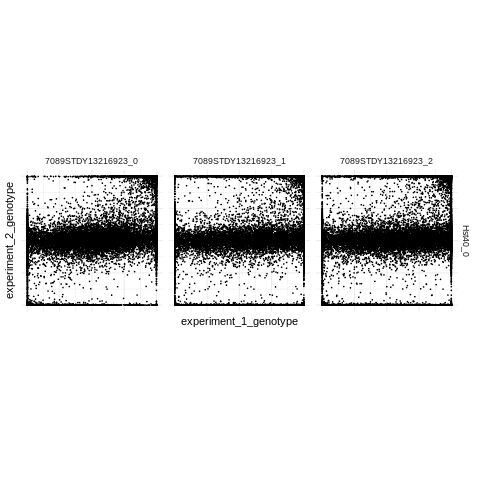

In [22]:
%%R -i targetID
plot_result(ID=targetID, Donor='Hst40')

In [ ]:
'''
obsnames = clusters_all.index[(clusters_all['sample']==targetID)&(clusters_all['assignment']==    )]
clusters_all.loc[obsnames,'donor_assignment'] = 'Hst40'
targetID
'''

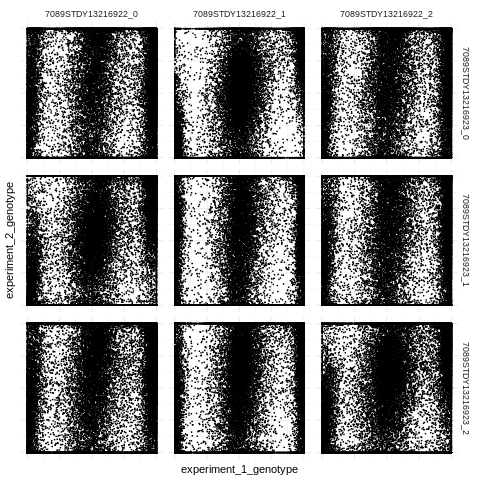

In [37]:
%%R
output_dir = '/nfs/team205/heart/mapped/cellranger-arc200/SOC_out/'
plot_cross_vaf(experiment_1_path = paste0(output_dir,'7089STDY13216922_BHF_F_Hea13242529','/ATAC_SOC_common_variants/'), 
                   experiment_2_path = paste0(output_dir,'7089STDY13216923_BHF_F_Hea13242530','/ATAC_SOC_common_variants/'), 
                   experiment_1_name = '7089STDY13216922',
                   experiment_2_name = '7089STDY13216923')

# Save clusters dataframe

In [26]:
clusters_all.head()

,sample,barcode,status,assignment,log_prob_singleton,log_prob_doublet,cluster0,cluster1,cluster2,donor_assignment
obsnames,,,,,,,,,,
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1,7089STDY13216920_BHF_F_Hea13242527,GCCCTCATCCTAGTAA-1,singlet,1,-1804.326000,-2214.313429,-3702.970109,-1804.326000,NaN,Hst40
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1,7089STDY13216920_BHF_F_Hea13242527,ACTCGCTTCCTAGTAA-1,singlet,0,-2300.029401,-2917.765214,-2300.029401,-4878.822776,NaN,Hst39
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1,7089STDY13216920_BHF_F_Hea13242527,TGGTCCTTCCGTGACA-1,singlet,0,-7138.100603,-8752.227197,-7138.100603,-15143.684314,NaN,Hst39
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1,7089STDY13216920_BHF_F_Hea13242527,TTCAGTTTCCGCTAGA-1,singlet,1,-16501.683493,-20232.559001,-36208.064251,-16501.683493,NaN,Hst40
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1,7089STDY13216920_BHF_F_Hea13242527,GTCAATATCATCCACC-1,singlet,0,-15506.974212,-16020.863109,-15506.974212,-25471.286877,NaN,Hst39


In [27]:
clusters_all.to_csv('/nfs/team205/heart/mapped/cellranger-arc200/SOC_out/SOC-clusters_multiome-foetal_20221221.csv')

# Proportions

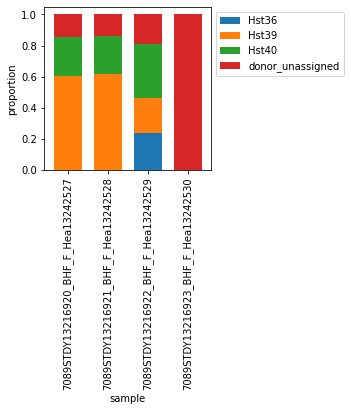

##### 7089STDY13216920_BHF_F_Hea13242527 #####
Hst39               16670
Hst40                6894
donor_unassigned     3934
Name: donor_assignment, dtype: int64

##### 7089STDY13216921_BHF_F_Hea13242528 #####
Hst39               14867
Hst40                5944
donor_unassigned     3400
Name: donor_assignment, dtype: int64

##### 7089STDY13216922_BHF_F_Hea13242529 #####
Hst40               7408
Hst36               5093
Hst39               4786
donor_unassigned    4115
Name: donor_assignment, dtype: int64

##### 7089STDY13216923_BHF_F_Hea13242530 #####
donor_unassigned    1873
Name: donor_assignment, dtype: int64



In [28]:
df = clusters_all.copy()
plt.rcParams['figure.figsize'] = 3,3
tmp = pd.crosstab(df['sample'], df['donor_assignment'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.7)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()
plt.show()

for sam in multiplexed_IDs:
    df_s = df[df['sample']==sam]
    print(f'##### {sam} #####')
    print(df_s['donor_assignment'].value_counts())
    print('')

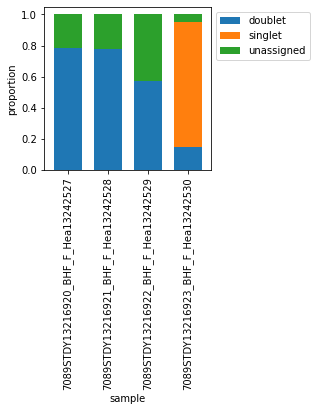

##### 7089STDY13216920_BHF_F_Hea13242527 #####
doublet       3086
unassigned     848
Name: status, dtype: int64

##### 7089STDY13216921_BHF_F_Hea13242528 #####
doublet       2655
unassigned     745
Name: status, dtype: int64

##### 7089STDY13216922_BHF_F_Hea13242529 #####
doublet       2362
unassigned    1753
Name: status, dtype: int64

##### 7089STDY13216923_BHF_F_Hea13242530 #####
singlet       1508
doublet        280
unassigned      85
Name: status, dtype: int64



In [30]:
# reason why donor was unassigned
df = clusters_all[clusters_all['donor_assignment']=='donor_unassigned']
plt.rcParams['figure.figsize'] = 3,3
tmp = pd.crosstab(df['sample'], df['status'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.7)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()
plt.show()

for sam in multiplexed_IDs:
    df_s = df[df['sample']==sam]
    print(f'##### {sam} #####')
    print(df_s['status'].value_counts())
    print('')

# Doublets and scrublet score

In [33]:
# post-cellbender anndata
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/QC/multiome_RNA_foetal_prefilter.h5ad',
                     backed = 'r')
# only multiplexed data
adata = adata[adata.obs['combinedID'].isin(multiplexed_IDs)]

adata

View of AnnData object with n_obs × n_vars = 74984 × 36601 backed at '/nfs/team205/heart/anndata_objects/Foetal/QC/multiome_RNA_foetal_prefilter.h5ad'
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-17', 'ambient_expression-18', 'ambient_expression-19', 'ambient_expression-2', 'ambient_expression-20', 'ambient_expression-21', 'ambient_expression-22', 'ambient_expression-23', 'ambient_expression-24', 'ambient_expression-25', 'ambient_

In [42]:
sc.settings.set_figure_params(dpi=120)

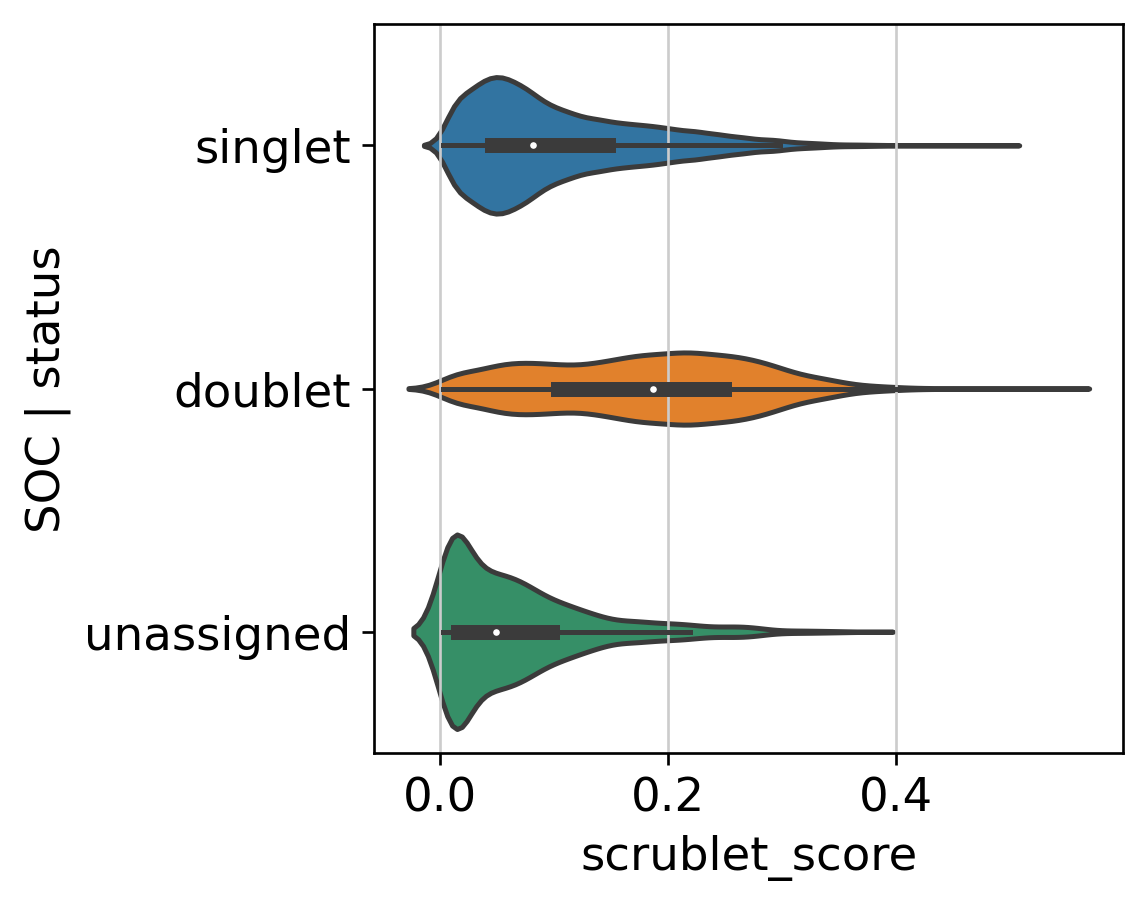

singlet       63170
doublet        8383
unassigned     3431
Name: SOC | status, dtype: int64

In [43]:
# add
col_to_add = ['status', 'assignment', 'log_prob_singleton',
               'log_prob_doublet', 'cluster0', 'cluster1', 'cluster2',
               'donor_assignment']
df = adata.obs.copy()
df[[f'SOC | {x}' for x in col_to_add]] = clusters_all[col_to_add].reindex(df.index)

sns.violinplot(data=df, x="scrublet_score", y="SOC | status")
plt.show()

df['SOC | status'].value_counts()